## Show the segmentation

Using MedicalDecathlonDataset for Task04_Hippocampus
[IMPORTANT]: currently using the same transforms for validation and test.
Dataset size (test phase): 260


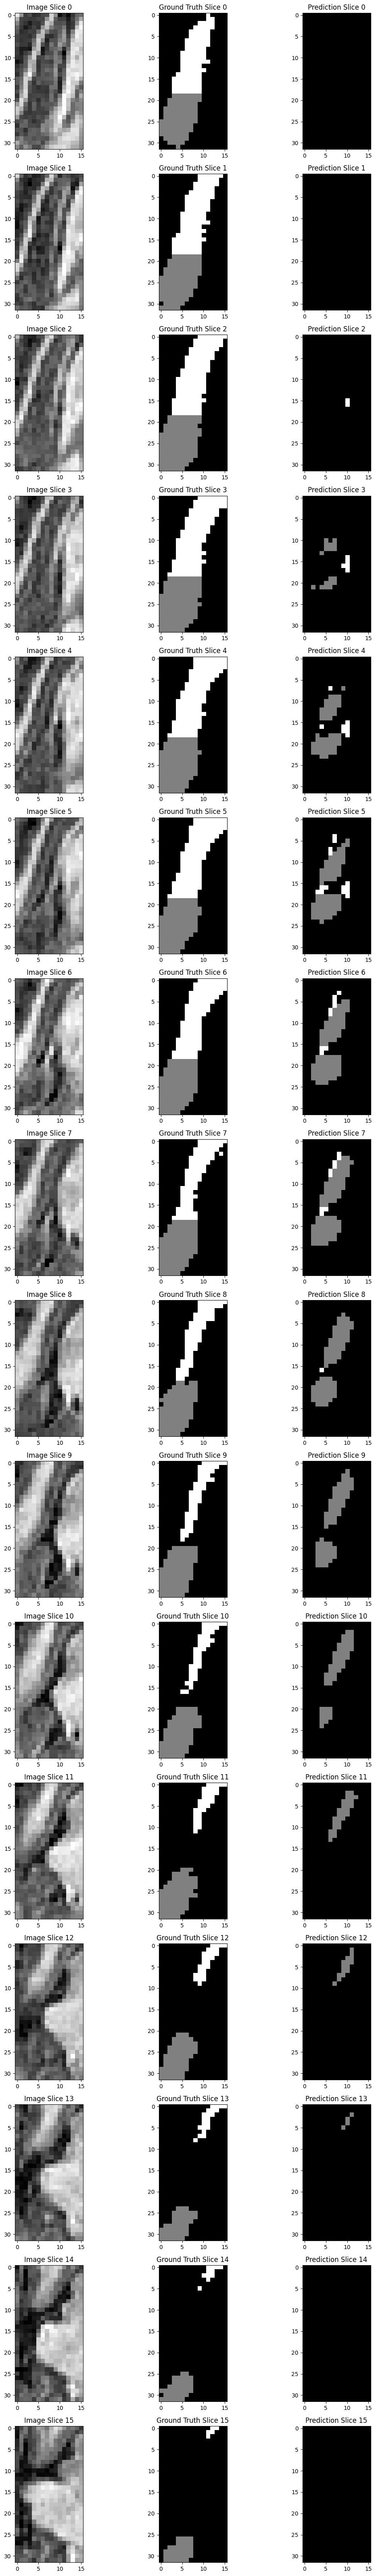

In [ ]:
from ast import mod
import pathlib
import numpy as np
from omegaconf import DictConfig, OmegaConf
from typing import Dict, Tuple

import torch
import matplotlib.pyplot as plt

import data
from data.datasets import MedicalDecathlonDataset, BrainTumourDataset
from models.unet3d import UNet3D

from models.factory import create_model



# ------ Change only this for test of a trained model ------
model_dir_str = "trained_models/ms-unet3d/Task04_Hippocampus/2025-04-20_13-48-59"
# ----------------------------------------------------------




model_dir = pathlib.Path(model_dir_str)
if not model_dir.is_dir():
    raise FileNotFoundError(f"Model directory not found: {model_dir}")

model_path = f"{model_dir}/best_model.pth"
cfg = OmegaConf.load(f"{model_dir}/config.yaml")


try:
    path_parts = model_dir.parts
    # model_architechture = path_parts[-3]
    task_name = path_parts[-2]
    inference_model_name = path_parts[-1]
except IndexError:
    raise ValueError(f"Could not parse architecture/task/name from model_dir: {model_dir}. Expected structure like 'trained_models/arch/task/name'")





if not isinstance(cfg, DictConfig):
    raise TypeError("cfg must be a DictConfig.")

if task_name == "Task01_BrainTumour":
    print(f"Using BrainTumourDataset for {task_name}")
    dataset = BrainTumourDataset(cfg, phase='test')
elif task_name == "Task04_Hippocampus":
    print(f"Using MedicalDecathlonDataset for {task_name}")
    dataset = MedicalDecathlonDataset(cfg, phase='test')
else:
    # Add handling for other tasks or raise an error
    raise ValueError(f"Unsupported task_name for dataset selection: {task_name}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = cfg.active_architecture

model = create_model(cfg, model_name).to(device)

checkpoint = torch.load(model_path, map_location=device)
model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model.to(device)  # Move the model to the appropriate device
model.eval()


#samples idx list to check: (6,)
sample_idx = 0

# ... after dataset creation ...
print(f"Dataset size (test phase): {len(dataset)}")
if len(dataset) > 0:
    sample_idx = min(len(dataset)-1, 392) # Or any index < len(dataset)
    image, gt = dataset[sample_idx]
else:
    print("Error: Test dataset is empty!")
    # Handle the case where the dataset has no samples
    exit()
# ... rest of the code ...

image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)

# Add batch dimension and move to device
image_batch = image.unsqueeze(0).to(device)  # shape: (1, C, D, H, W)

# Run inference
with torch.no_grad():
    output = model(image_batch)
    # If model returns deep supervision outputs, take the final prediction
    if isinstance(output, (tuple, list)):
        output = output[0]
    # Get predicted labels: (B, D, H, W)
    pred = torch.argmax(output, dim=1).squeeze(0).cpu()  

# Convert tensors to numpy arrays for visualization
# Remove channel dimension from image for visualization: (D, H, W)
image_np = image.squeeze(0).cpu().numpy()
gt_np = gt.cpu().numpy()
pred_np = pred.numpy()

# Choose 3 slices evenly spaced along the depth dimension
depth = image_np.shape[0]
num_slices = min(depth, 66)
slice_indices = np.linspace(0, depth-1, num=num_slices, dtype=int)


# Create subplots: one row per slice and 3 columns for image, ground truth, and prediction
fig, axes = plt.subplots(nrows=num_slices, ncols=3, figsize=(12, 4 * num_slices))
for i, slice_idx in enumerate(slice_indices):
    slice_2d = image_np[slice_idx]
    # slice_2d = np.rot90(slice_2d)
    axes[i, 0].imshow(slice_2d, cmap="gray")
    axes[i, 0].set_title(f"Image Slice {slice_idx}")
    
    gt_2d = gt_np[slice_idx]
    # gt_2d = np.rot90(gt_2d)
    axes[i, 1].imshow(gt_2d, cmap="grey", vmin=0, vmax=cfg.dataset.num_classes - 1)

    axes[i, 1].set_title(f"Ground Truth Slice {slice_idx}")
    pred_2d = pred_np[slice_idx]
    # pred_2d = np.rot90(pred_2d)
    axes[i, 2].imshow(pred_2d, cmap="grey", vmin=0, vmax=cfg.dataset.num_classes - 1)
    axes[i, 2].set_title(f"Prediction Slice {slice_idx}")

    # for ax in axes[i]:
    #     ax.axis("off")



plt.tight_layout()
plt.show()

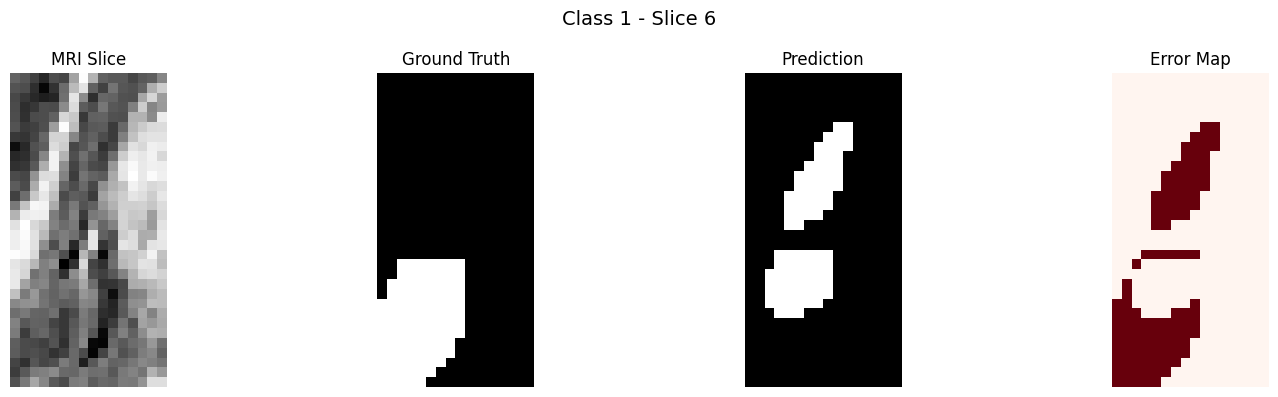

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.__config__ import show

import matplotlib.pyplot as plt
import numpy as np

def show_prediction(image, gt_mask, pred_mask, slice_idx=None, class_id=1):
    gt_binary = (gt_mask == class_id)
    pred_binary = (pred_mask == class_id)

    if slice_idx is None:
        z_coords = np.where(gt_binary)[0]
        slice_idx = z_coords[len(z_coords)//2] if len(z_coords) > 0 else gt_mask.shape[0] // 2

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image[slice_idx], cmap='gray')
    plt.title("MRI Slice")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_binary[slice_idx], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_binary[slice_idx], cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    error_map = np.logical_xor(gt_binary[slice_idx], pred_binary[slice_idx])
    plt.imshow(error_map, cmap='Reds')
    plt.title("Error Map")
    plt.axis('off')

    plt.suptitle(f"Class {class_id} - Slice {slice_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()


show_prediction(image_np, gt_np, pred_np, class_id=1)


## Visualization of images!

### Setup

In [9]:
from ast import mod
import numpy as np
from omegaconf import DictConfig, OmegaConf
from typing import Dict, Tuple

import torch
import matplotlib.pyplot as plt

import data
from data.datasets import MedicalDecathlonDataset, BrainTumourDataset
from models.ms_unet3d import MSUNet3D

# ras+ ORIENTATION
# class imbalance

# task_name = "Task04_Hippocampus"
task_name = "Task01_BrainTumour"
inference_model_name = "2025-03-31_13-44-04"

model_dir = f"trained_models/unet3d/{task_name}/{inference_model_name}"
model_path = f"{model_dir}/best_model.pth"

cfg = OmegaConf.load(f"{model_dir}/config.yaml")

if not isinstance(cfg, DictConfig):
    raise TypeError("cfg must be a DictConfig.")

# dataset = MedicalDecathlonDataset(cfg, phase="test")
dataset = BrainTumourDataset(cfg, phase='train')

model = MSUNet3D(
    in_channels=1,
    num_classes=cfg.dataset.num_classes,
    n_filters=cfg.model.n_filters,
    dropout=cfg.training.dropout,
    batch_norm=True,
    inference_fusion_mode=cfg.model.deep_supervision.inference_fusion_mode,
    depth=cfg.model.depth,
    deep_supervision_levels=cfg.model.deep_supervision.levels
)



TypeError: MSUNet3D.__init__() missing 2 required positional arguments: 'ds' and 'ms'

### Visualize predetermined sample and random slices

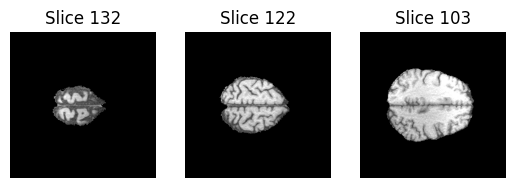

In [ ]:
sample_idx = 300

image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)
slice = 104 # or 126

# three random slices
# Pick three random slices along the depth dimension
depth = image.shape[3]
slices = np.random.choice(depth, size=3, replace=False)

# Plot the slices
for i, slice_idx in enumerate(slices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image[0, :, :, slice_idx], cmap='gray')
    plt.title(f"Slice {slice_idx}")
    plt.axis('off')
plt.show()

### Visualize predetermined sample and slice

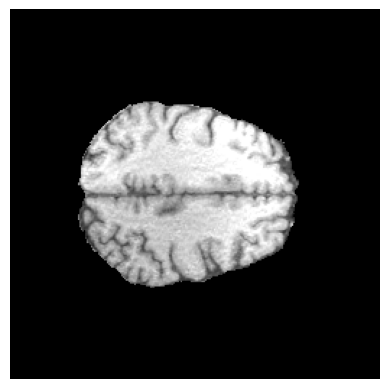

In [ ]:
sample_idx = 300

image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)
slice = 104 # or 126

#Skew image


plt.imshow(image[0, :, :, slice_idx], cmap='gray')
plt.axis('off')
plt.show()